### Imports

In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll, make_s_curve, make_moons

## Parameters:

In [2]:
batch_size = 128
schedules = ['linear', 'quad', 'sigmoid', 'cosine']
num_steps, start, end = 100, 1e-4, 5e-3
mode = "DDIM" # DDPM or DDIM
iterations = 3000

# Data Preparation:

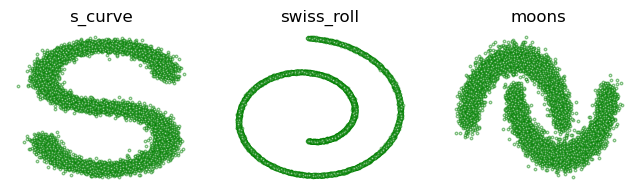

In [3]:

datasets = {
    "s_curve": make_s_curve(10**4, noise=0.1)[0][:, [0, 2]] / 10.0,
    "swiss_roll": make_swiss_roll(10**4, noise=0.1)[0][:, [0, 2]] / 10.0,
    "moons": make_moons(10**4, noise=0.1)[0]
}

fig, axes = plt.subplots(1, 3, figsize=(8, 2))
for ax, (name, data) in zip(axes, datasets.items()):
    ax.scatter(*data.T, alpha=0.5, color='white', edgecolor='green', s=3)
    ax.axis('off')
    ax.set_title(name)

# Diffusion in General:

Starting with a sample $x_0 \sim q(x_0)$, it has a forward process which adds Gaussian noise over $T$ time steps. The process can be defined as
> $q(x_{1:T}|x_0) = \Pi_{i=1}^T q(x_{t}|x_{t-1})$ with $q(x_t|x_{t-1})=\mathcal{N}(x_t; \sqrt{1-\beta_t}x_{t-1};\beta_t\mathbf{I})$ and $\{\beta_t\in (0,1)\}_{t=1}^T$


The sequence of $\beta_t$`s can be chosen in different ways, and optimized, we refer to this as scheduler. Here are some ways (note that the end point should be such that $\beta_t\ll1$):

# Sequence Scheduler:

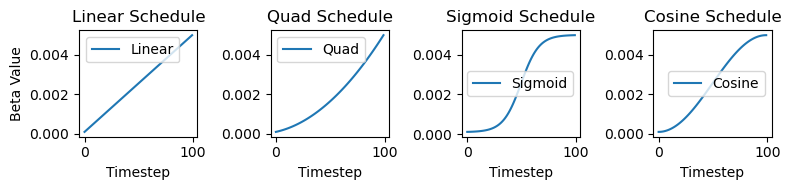

In [4]:
def make_beta_seq(schedule='linear', n_timesteps=1000, start=1e-4, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    elif schedule == "cosine":
        timesteps = torch.linspace(0, 1, n_timesteps)
        betas = (1-(torch.cos(timesteps * torch.pi) + 1) / 2)
        betas = betas * (end - start) + start 
    return betas


# Plotting the sequences
fig, axes = plt.subplots(1, 4, figsize=(8, 2))
for ax, schedule in zip(axes, schedules):
    betas = make_beta_seq(schedule=schedule, n_timesteps=num_steps, start=start, end=end)
    ax.plot(betas, label=schedule.capitalize())
    ax.set_title(f'{schedule.capitalize()} Schedule')
    if schedule == 'linear':
        ax.set_ylabel('Beta Value')
    ax.set_xlabel('Timestep')
    ax.legend()

plt.tight_layout()
plt.show()

# Forward Process:
#### (Make the samples noisy)

Note that one can sample directly from
> $q(x_t|x_0)=\mathcal{N}(x_t; \sqrt{\bar{\alpha}_t}x_{0};(1-\bar{\alpha}_t)\mathbf{I})$

without going through the whole chain of the process. For that we define $\alpha_t=(1-\beta_t)$ and $\bar{\alpha_t}=∏_{t=1}^T\alpha_t$.

In [5]:
betas = make_beta_seq(schedule="linear", n_timesteps=num_steps, start=start, end=end)
alphas = 1 - betas
alphas_bar = torch.cumprod(alphas, 0)

Due to the Gaussian property that for $\epsilon\sim\mathcal{N}(0,1)$, we have $\mu+\sigma\epsilon \sim \mathcal{N}(\mu, \sigma^2)$, we can generate the noisy samples of $x_T$ (or any other $x_t$) by utilizing the Gaussian property $\mu x_0+\sigma\epsilon$, plugging in $\alpha$ we get:

>$q(x_t|x_0) = \sqrt{\bar{\alpha_t}} x_0 + (1-\bar{\alpha_t})*\epsilon$

In [6]:
def q_x(x_0, t, noise): #q(x_t | x_0)
    coeff1 = torch.sqrt(alphas_bar)[t].unsqueeze(-1)
    coeff2 = torch.sqrt(1 - alphas_bar)[t].unsqueeze(-1)
    return coeff1 * x_0 + coeff2 * noise

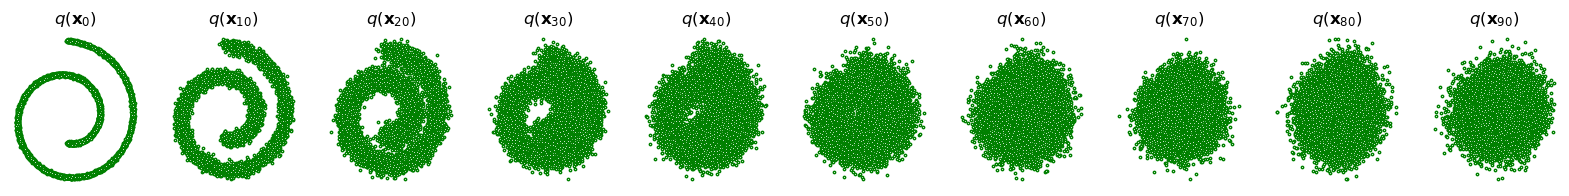

In [7]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    x_0 = torch.from_numpy(datasets['swiss_roll'])
    noise = torch.randn_like(x_0)
    q_i = q_x(x_0=x_0, t=torch.tensor([i * 10]), noise=noise)
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='white',edgecolor='green', s=3)
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

# Reverse process / sampling:

Now we want to reverse the process, and get $q(x_{t-1}|x_{t})$, i.e., given the further noisy sample in the step, we want to produce the less noisy sample from before. If we can do that, we can sample from clean noise, representing a random noisy $x_T$, reverse the whole chain, and arrive at a new data sample $x_0^\dagger$. Here we utilize, that all $\beta_t \ll 1$, then the distirbution class of the reverse step is the same as the forward step, i.e., Gaussian. Now we need to learn a *parametrized* approximation
> $p_{\theta}(x_{t-1}|x_{t})=\mathcal{N}(x_{t};\mu_{\theta}(x_t),\sigma_{\theta}(x_t))$ of the reverse step.

After a lengthy derivation, the paper [Ho et al., DDPM, https://arxiv.org/abs/2006.11239 ] arrives at the mean estimate
>$\mu_{\theta}=\frac{1}{\sqrt{\bar{\alpha}_t}} \left(x_t - \frac{b_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_{\theta}(x_t) \right)$.

Here, the $\epsilon_{\theta}$ term stands for the noise and is learned as a prediction of the noise $\epsilon$ from $x_t$

>$L = \mathbb{E}_{t\in U[1:T],x_0}\left[|| \epsilon - \epsilon_{\theta}(x_t) ||^2\right]$.

Breaking this down, $\epsilon_{\theta}(\cdot)$ will be represented by a parametrized neural network:

### DDIM Sampling:


>$x_{t-1}=\sqrt{\frac{\bar{\alpha}_{t-1}}{\bar{\alpha}_t}} \left(x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_{\theta}(x_t) \right)+\sqrt{1-\bar{\alpha}_{t-1}-\sigma_t^2} \epsilon_{\theta}(x_t)+\sigma_t\epsilon_{\theta}(x_t)$

where $\sigma_t$ is a factor to choose the style of the model. For $\sigma_t:=0$ the sampling becomes deterministic, yielding the known DDIM function:

>$x_{t-1}=\sqrt{\frac{\bar{\alpha}_{t-1}}{\bar{\alpha}_t}} \left(x_t - \sqrt{1-\bar{\alpha}_t} \epsilon_{\theta}(x_t) \right)+\sqrt{1-\bar{\alpha}_{t-1}} \epsilon_{\theta}(x_t)$

# Diffusion (epsilon) Model:

In [8]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super().__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        nn.init.uniform_(self.embed.weight)

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y).view(-1, self.num_out)
        return gamma * out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super().__init__()
        first_layer = ConditionalLinear(2, 128, n_steps)
        middle_layers = [ConditionalLinear(128, 128, n_steps) for _ in range(2)]
        self.layers = nn.ModuleList([first_layer] + middle_layers)
        self.final = nn.Linear(128, 2)

    def forward(self, x, y):
        for layer in self.layers:
            x = F.softplus(layer(x, y))
        return self.final(x)

model = ConditionalModel(num_steps)

# Sampling

In [9]:
# Sample with the help of our epsilon model
def p_sample(model, x_t, t, mode='DDIM'):
    t = torch.tensor([t])
    factor = (betas[t] / torch.sqrt(1-alphas_bar)[t]).unsqueeze(-1)
    eps_theta = model(x_t, t)
    mu_theta = (x_t - (factor * eps_theta)) / torch.sqrt(alphas)[t].unsqueeze(-1)
    
    if mode == 'DDIM':
        if t > 0: 
            x_prev = torch.sqrt(alphas_bar[t-1]/alphas_bar[t]) * (x_t - torch.sqrt(1.0 - alphas_bar[t]) * eps_theta)
            x_prev += torch.sqrt(1.0 - alphas_bar[t-1]) * eps_theta
            return x_prev
        else:
            return x_t
    else:  # DDPM mode
        z = torch.randn_like(x_t)
        sigma_t = betas[t].sqrt().unsqueeze(-1)
        return mu_theta + sigma_t * z

In [10]:
def p_sample_loop(model, shape, num_steps, mode='DDIM'):
    x_t = torch.randn(shape)
    x_seq = [x_t]
    
    if mode == 'DDIM':
        timesteps = range(0, num_steps, 2) # start, end, step_size
    else:
        timesteps = range(num_steps)

    for t in reversed(timesteps):
        x_t = p_sample(model, x_t, t, mode)
        x_seq.append(x_t)

    return x_seq

# Loss Term

In [11]:
# This creates the loss term L

def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, num_steps, size=(batch_size,))

    # model input
    noise = torch.randn_like(x_0)
    x_t = q_x(x_0, t, noise)
    eps_theta = model(x_t, t)
    return (noise - eps_theta).square().mean() # =: Loss L

# Training

Iteration: 1 Loss: 1.12119460105896


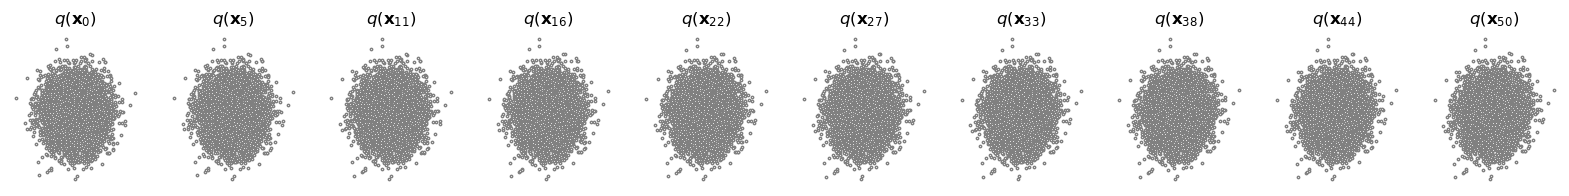

Iteration: 301 Loss: 0.3492967486381531


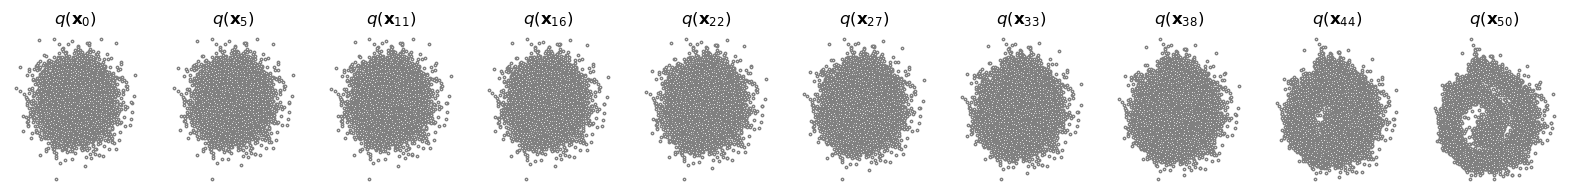

Iteration: 601 Loss: 0.3837714195251465


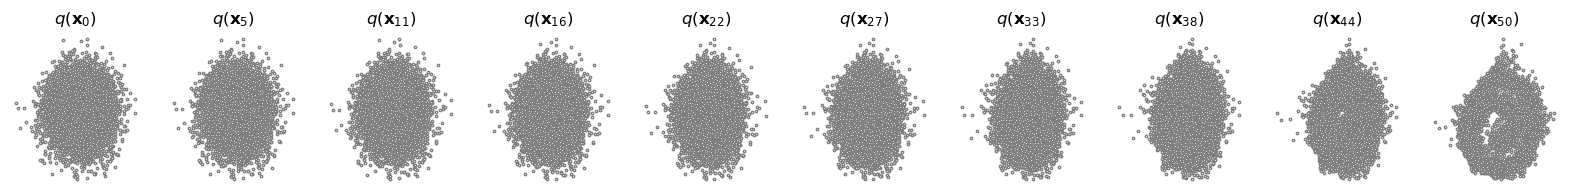

Iteration: 901 Loss: 0.35198938846588135


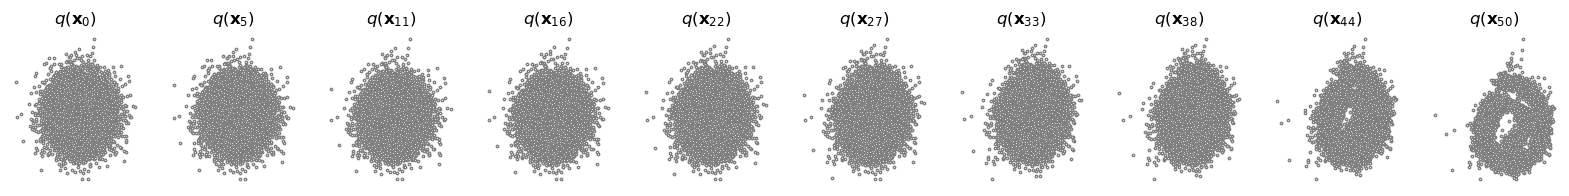

Iteration: 1201 Loss: 0.7567307353019714


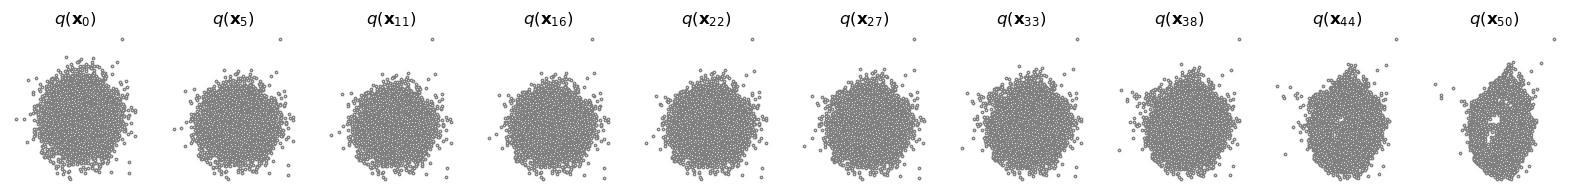

Iteration: 1501 Loss: 0.35094019770622253


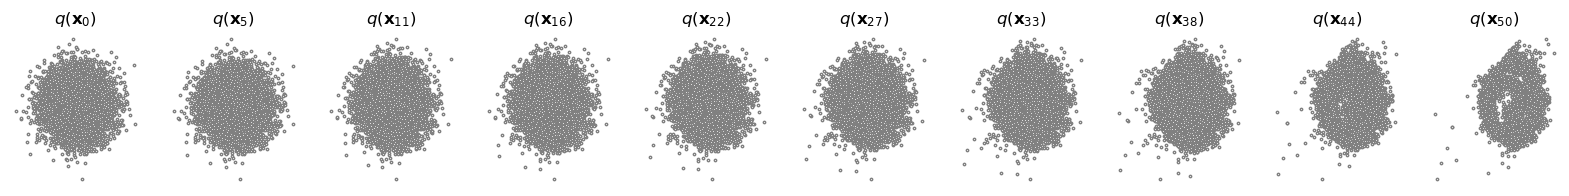

KeyboardInterrupt: 

In [12]:
data_tensor = torch.tensor(datasets['swiss_roll'], dtype=torch.float32)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for t in range(iterations):
    permutation = torch.randperm(data_tensor.shape[0])
    for i in range(0, data_tensor.shape[0], batch_size):
        optimizer.zero_grad()
        indices = permutation[i:i + batch_size]
        batch_x = data_tensor[indices]
        loss = noise_estimation_loss(model, batch_x)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        optimizer.step()

    if (t % (iterations//10) == 0):
        print(f"Iteration: {t+1} Loss: {loss}")

        x_seq = p_sample_loop(model, data_tensor.shape, num_steps, mode)
        
        # Determine indices for plotting based on mode
        if mode == 'DDIM':
            num_samples_to_plot = 10
            num_samples = len(x_seq)
            if num_samples < num_samples_to_plot:
                plot_indices = np.arange(num_samples)
            else:
                plot_indices = np.linspace(0, num_samples-1, num=num_samples_to_plot, dtype=int)
        else:  # DDPM
            plot_indices = [0] + list(range(10, 101, 10))

        # Create subplots based on the number of indices
        fig, axs = plt.subplots(1, len(plot_indices), figsize=(20, 2))

        # Plot the samples
        for i, idx in enumerate(plot_indices):
            cur_x = x_seq[idx].detach()
            axs[i].scatter(cur_x[:, 0], cur_x[:, 1], color='white', edgecolor='gray', s=3)
            axs[i].set_axis_off()
            axs[i].set_title(f'$q(\\mathbf{{x}}_{{{idx}}})$')

        plt.show()

We can now sample with the formula $x_{t-1}= \mu_{\theta} + \sigma_t z$, where \mu_{\theta} is given by the formular above and the resulting neural network output, $\sigma_t$ is just $\sqrt{\beta}$ and $z\sim \mathbb{N}(0,I)$. THis is done in p_sample, and then we need to loop over the whole sequence p_sample_loop.